A few spot tests to decide on details for counting bed and shoreline
interactions.

Namely, choose a sinking groups and a rising group

Develop a basic counting for how close they are to the bed and
to shallow water

Pull some trajectories, plot to make sure it all makes sense.

Plot distributions and figure a tolerance or a few tolerances.

In [219]:
from stompy.model.fish_ptm import ptm_tools
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from stompy import utils
from stompy.grid import unstructured_grid
import postproc_dask as post
import six

%matplotlib notebook

In [220]:
six.moves.reload_module(post)

<module 'postproc_dask' from '/home/rusty/src/microplastic_sfbay/postprocess/postproc_dask.py'>

In [221]:
import cfg_v01 
cfg=dict(cfg_v01.cfg)

In [222]:
grp=cfg['ptm_base_dir']+"/chunk00/20171018/Alameda_Creek_down5000_rel20171018_bin.out"

In [223]:
# Hydro timestamps
cfg['hydro_timestamps']=post.load_hydro_timestamps(cfg['sun_paths'])

In [224]:
pbf=ptm_tools.PtmBin(grp)

In [225]:
suffix="-v01.nc"
info=xr.open_dataset(grp+suffix)

In [226]:
hyd_i=post.t_to_idx(info.time.values[0],cfg)

In [227]:
six.moves.reload_module(post)
hyd=post.hydro_ds(hyd_i,cfg)

In [228]:
grid=unstructured_grid.UnstructuredGrid.read_ugrid(hyd,dialect='fishptm')

Dev for calculating the time series
--


In [200]:
# Time series of distance to bed and watercolumn depth
d_bed=np.full( (info.dims['time'],info.dims['id']), np.nan, np.float32)
h    =np.full( (info.dims['time'],info.dims['id']), np.nan, np.float32)
X    =np.full( (info.dims['time'],info.dims['id'],2), np.nan, np.float64)
cstat=np.full( (info.dims['time'],info.dims['id']),-1,np.int16)

In [201]:
# And dry cells for a given time step            
six.moves.reload_module(post)        
CS=post.CellStatus(cfg=cfg,grid=grid)

# CS.fig_status()

INFO:UnstructuredGrid:Recalculating edge to cells


In [202]:
for tid,t in utils.progress(enumerate(pbf.time)):
    _,particles=pbf.read_timestep(tid)
    pid=particles['id']-1
    z_part=particles['x'][:,2]
    z_surf=info.z_surf.isel(time=tid,id=pid).values
    cell=info.cell.isel(time=tid,id=pid).values
    z_bed=grid.cells['z_bed'][cell]
    d_bed[tid,pid]=z_part - z_bed
    h[tid,pid]    =z_surf - z_bed
    X[tid,pid] = particles['x'][:,:2]
    
    # And check whether we're adjacent to a boundary or 
    # dry cell
    # Pretty slow. 0.2 seconds per call, most of which is in cell_to_cells.
    # Got that down to 0.01s per call.
    cell_stats=CS(np.datetime64(t))
    cstat[tid,pid]=cell_stats[cell]

INFO:utils:805
INFO:utils:1602


<IPython.core.display.Javascript object>


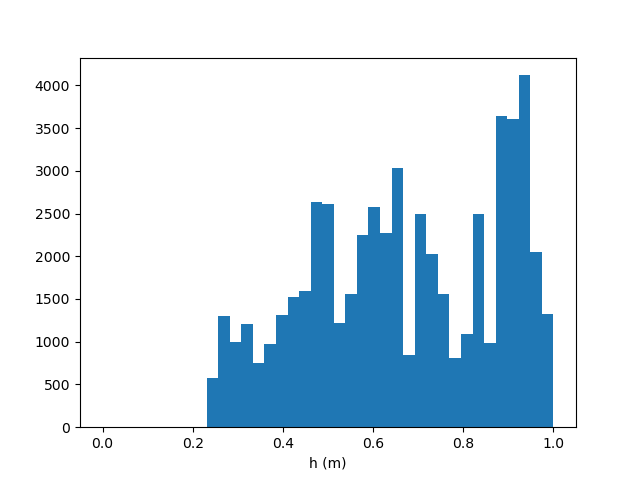

<IPython.core.display.Javascript object>


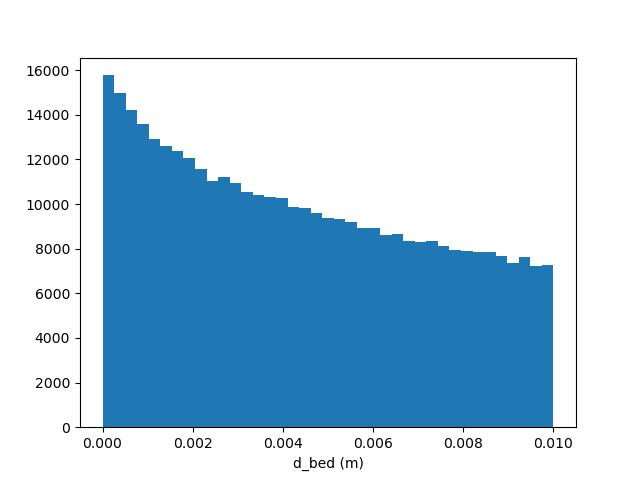

In [28]:
plt.figure()
# h
plt.hist(h[np.isfinite(h)],bins=np.linspace(0,1,40))
plt.xlabel('h (m)')
# d_bed
plt.figure()
plt.hist(d_bed[np.isfinite(d_bed)],bins=np.linspace(0,0.01,40))
plt.xlabel('d_bed (m)')
None

In [ ]:
# Something is weird. No dry cells in the domain?
# min of h is 0.20
# Check the regular average output: same deal.
# I only have original average output for merged021, but the ptm
# hydro looks the same for merged_022 and 021.

# Nothing seems this large in the suntans code.
# suntans.dat for merged022 has minimum_depth=0.1
# also dzsmall=0.1
# sure enough, runs had dzmin_surface=0.25.
# And evaporation is letting a small number of cells fall to 0.20.
# Is there anything in the ctop/cbot that signifies dry? nope. ctop=cbot
# occurs for h anywhere from 0.20 to 1.0.
# Is it enough to then just test for h<=0.25+eps?
# In the code, what is the difference between dzmin_surface
# and DRYCELLHEIGHT?
# When dzmin_surface is larger than DRYCELLHEIGHT (as it was)
# then DRYCELLHEIGHT doesn't come into play.
# ctop/cbot does not tell us anything more about dry cells.
# ctop=cbot for cells with h ranging from 0.2 to 1.0m.

# Since in some cases the shoreline is not well-resolved,
# should also track how often particles in a boundary cell.
# Should it be a boundary cell, a cell adjacent to a dry cell,
# or something else?
# Say you're a buoyant particle, you could get blown to a shoreline,
# but with the stairstepped bed you might have to stop getting blown
# in a particular direction when you hit the wetting front.  So you're
# local cell might still be deep, but you're artificially prevented from
# going into the shore and beaching. In that case I'd want to know that this
# particle was adjacent to a dry cell.
# So at each step, have to load the hydro, mark boundary cells, mark dry
# cells, and cells adjacent to a dry cell. Count how often particles are
# in a dry cell, and how often adjacent to a dry or boundary cell.

# After looking more closely at sample output, seems that flow BC cells
# should count as boundary. Sinking particles sometimes clump up here,
# and they should effectively be deposited in that case

<IPython.core.display.Javascript object>


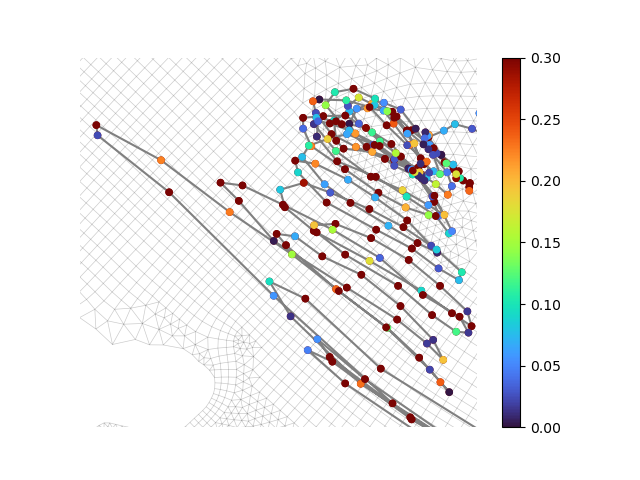

In [212]:
# Follow a few sinking particles, make sure the trajectory seems
# consistent with h and d_bed
# 
fig,ax=plt.subplots()

zoom=(551404.2955731227, 600474.4273861515, 4132843.0835015085, 4178549.536924128)

grid.plot_edges(color='k',lw=0.5,alpha=0.2,ax=ax,clip=zoom)

pid=1860
ax.plot(X[:,pid,0],X[:,pid,1],'-',color='0.5')
scat=ax.scatter(X[:,pid,0],X[:,pid,1],20,h[:,pid],cmap='turbo',zorder=3)
scat.set_clim([0.2,0.3])
#scat=ax.scatter(X[:,pid,0],X[:,pid,1],20,cstat[:,pid],cmap='Accent',zorder=3)
#scat.set_clim([-0.5,7.5])
scat=ax.scatter(X[:,pid,0],X[:,pid,1],20,d_bed[:,pid],cmap='turbo',zorder=3)
scat.set_clim([0.0,0.3])


plt.axis('tight')
plt.axis('equal')
plt.axis('off')
plt.axis(zoom)
plt.colorbar(scat)

In [218]:
np.arange(100,dtype=np.int16).cumsum().dtype

dtype('int64')

<IPython.core.display.Javascript object>


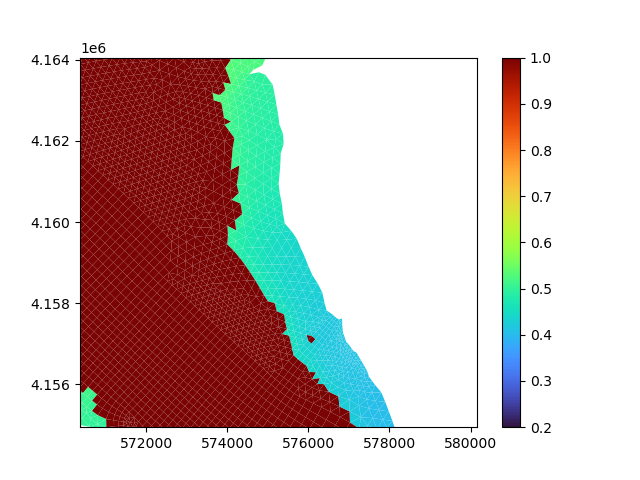

(570371.335389721, 580153.4776669749, 4155852.8332768218, 4163142.1070382604)

In [85]:
# How well is the wetting front resolved?  Do I need
# to record time in boundary cells, too?
ti=4

plt.figure()
h_cell=(hyd['Mesh2_sea_surface_elevation'].isel(nMesh2_data_time=ti)
        + hyd['Mesh2_face_depth']).values
ccoll=grid.plot_cells(values=h_cell,cmap='turbo')
ccoll.set_clim([0.2,1.0])
plt.colorbar(ccoll)
plt.axis('tight')
plt.axis('equal')
plt.axis((570371.335389721, 580153.4776669749, 4155852.8332768218, 4163142.1070382604))

In [197]:
hyd

<xarray.Dataset>
Dimensions:                        (Two: 2, date_string_length: 19, nMaxMesh2_face_nodes: 8, nMesh2_data_time: 504, nMesh2_edge: 105877, nMesh2_face: 57124, nMesh2_layer_3d: 60, nMesh2_node: 48730)
Coordinates:
    Mesh2_face_x                   (nMesh2_face) float64 5.837e+05 ... 5.915e+05
    Mesh2_face_y                   (nMesh2_face) float64 4.146e+06 ... 4.213e+06
    Mesh2_edge_x                   (nMesh2_edge) float64 ...
    Mesh2_edge_y                   (nMesh2_edge) float64 ...
Dimensions without coordinates: Two, date_string_length, nMaxMesh2_face_nodes, nMesh2_data_time, nMesh2_edge, nMesh2_face, nMesh2_layer_3d, nMesh2_node
Data variables:
    Mesh2_node_x                   (nMesh2_node) float64 5.836e+05 ... 5.915e+05
    Mesh2_node_y                   (nMesh2_node) float64 4.146e+06 ... 4.213e+06
    Mesh2_edge_bc                  (nMesh2_edge) int32 2 2 1 0 0 2 ... 0 0 0 0 0
    Mesh2_edge_nodes               (nMesh2_edge, Two) int32 201 2279 ... 7064
    Mesh2_edge_faces               (nMesh2_edge, Two) int32 1608 -1 ... 57122
    Mesh2_face_nodes               (nMesh2_face, nMaxMesh2_face_nodes) int32 ...
    Mesh2_face_edges               (nMesh2_face, nMaxMesh2_face_nodes) int32 ...
    Mesh2_face_depth               (nMesh2_face) float64 7.888 6.621 ... 12.72
    Mesh2_edge_depth               (nMesh2_edge) float64 4.495 2.112 ... 12.72
    Mesh2_layer_3d                 (nMesh2_layer_3d) float64 3.655e+03 ... 0.0
    Mesh2_face_bc                  (nMesh2_face) int32 0 0 0 0 0 0 ... 0 0 0 0 0
    Mesh2                          int64 1
    Mesh2_data_time                (nMesh2_data_time) datetime64[ns] 2017-10-...
    Mesh2_data_time_string         (date_string_length, nMesh2_data_time) |S1 ...
    Mesh2_salinity_3d              (nMesh2_face, nMesh2_layer_3d, nMesh2_data_time) float64 ...
    Mesh2_vertical_diffusivity_3d  (nMesh2_face, nMesh2_layer_3d, nMesh2_data_time) float64 ...
    Mesh2_sea_surface_elevation    (nMesh2_face, nMesh2_data_time) float64 ...
    h_flow_avg                     (nMesh2_edge, nMesh2_layer_3d, nMesh2_data_time) float64 ...
    v_flow_avg                     (nMesh2_face, nMesh2_layer_3d, nMesh2_data_time) float64 ...
    Mesh2_edge_wet_area            (nMesh2_edge, nMesh2_layer_3d, nMesh2_data_time) float64 ...
    Mesh2_face_wet_area            (nMesh2_face, nMesh2_layer_3d, nMesh2_data_time) float64 ...
    Mesh2_edge_bottom_layer        (nMesh2_edge, nMesh2_data_time) int32 ...
    Mesh2_edge_top_layer           (nMesh2_edge, nMesh2_data_time) int32 ...
    Mesh2_face_bottom_layer        (nMesh2_face, nMesh2_data_time) int32 ...
    Mesh2_face_top_layer           (nMesh2_face, nMesh2_data_time) int32 ...
    Mesh2_face_water_volume        (nMesh2_face, nMesh2_layer_3d, nMesh2_data_time) float64 ...
Attributes:
    Description:  UnTRIM history file converted from SUNTANS output

Check output of info
--

Qualitative checks:
  * bed hits looks fine.
  * shore hits looks fine.

In [233]:
info.shore_hits

<xarray.DataArray 'shore_hits' (time: 1681, id: 2400)>
[4034400 values with dtype=int16]
Coordinates:
  * time     (time) datetime64[ns] 2017-10-18 2017-10-18T01:00:00 ... 2017-12-27
  * id       (id) int64 0 1 2 3 4 5 6 7 ... 2393 2394 2395 2396 2397 2398 2399

<IPython.core.display.Javascript object>


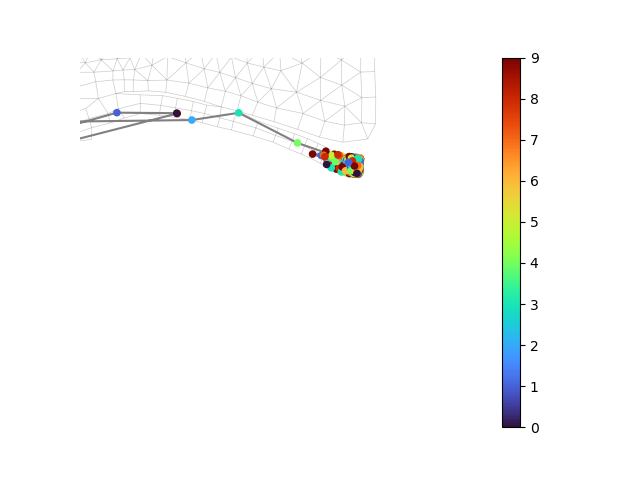

In [236]:
# 
fig,ax=plt.subplots()

zoom=(551404.2955731227, 600474.4273861515, 4132843.0835015085, 4178549.536924128)

grid.plot_edges(color='k',lw=0.5,alpha=0.2,ax=ax,clip=zoom)

pid=1860

ax.plot(X[:,pid,0],X[:,pid,1],'-',color='0.5')
#scat=ax.scatter(X[:,pid,0],X[:,pid,1],20,h[:,pid],cmap='turbo',zorder=3)
#scat.set_clim([0.2,0.3])
#scat=ax.scatter(X[:,pid,0],X[:,pid,1],20,cstat[:,pid],cmap='Accent',zorder=3)
#scat.set_clim([-0.5,7.5])
#scat=ax.scatter(X[:,pid,0],X[:,pid,1],20,d_bed[:,pid],cmap='turbo',zorder=3)
#scat.set_clim([0.0,0.3])

scat=ax.scatter(X[:,pid,0],X[:,pid,1],20,
                info['shore_hits'].isel(id=pid).values%10,cmap='turbo',zorder=3)
#scat.set_clim([0.2,0.3])

plt.axis('tight')
plt.axis('equal')
plt.axis('off')
plt.axis(zoom)
plt.colorbar(scat)